# Sampling strategy using a rosette CTD along transects in a rotated radiator grid

This code provides the coordinates (lon, lat, depth, time) of each CTD cast on a rotated sampling grid (information needed for navigation and to do OSSEs). It needs as inputs:

- Northwestern position (position where the sampling starts)
- Sampling strategy parameters: separation between casts, length of transects, separation between transects, number of transects, angle of the rotated grid, maximum depth of CTD profiles, time needed to do each cast 
- Ship velocity in knots
- Initial date and time of the sampling

Note that this strategy consists of a vessel moving from west to east sampling one transect, then moving down to the next transect, which will be sampled from east to west, and so on.

Also note that transects are not zonal, but they are forming an angle with the x-axis. The angle is positive counter-clockwise.



*Code written by Elisabet Verger-Miralles (UIB-IMEDEA, Spain) and Bàrbara Barceló-Llull (IMEDEA, Spain) in the framework of the FaSt-SWOT project to plan the FaSt-SWOT experiments. This code is based on the codes developed during the H2020 EuroSea project (Barceló-Llull, 2023). 11 April 2023.*

*The FaSt-SWOT project is funded by the Spanish Research Agency and the European Regional Development Fund (AEI/FEDER, UE) under Grant Agreement (PID2021-122417NB-I00)).*

*The EuroSea project is funded by the European Union’s Horizon 2020 research and innovation programme under grant agreement No 862626.*

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf
from matplotlib import dates as mdates
import pickle
from datetime import datetime, timedelta
import xarray as xr
import matplotlib.gridspec   as gridspec
import cartopy.crs           as ccrs   # import projections
import cartopy.feature       as cf     # import features
from cartopy.mpl.gridliner   import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean               as cmo

## Inputs to define the sampling strategy

- NW coordinate of the sampling domain > coordinates of cast 1 (top, left cast)

In [2]:
lon_ini = 3.45  
lat_ini = 39.2  

- Parameters to define the CTD sampling strategy

In [3]:
cast_res_km = 10   # separation between CTD casts [km]
dep_ctd_max = 500  # maximum depth of each CTD cast [m]     
num_rows    = 5    # number of transects
num_cols    = 6    # number of casts on each transect

- Check the time needed to do the CTD cast depending on the maximum depth

In [4]:
if dep_ctd_max == 1000:
    t_cast_min = 60  # [min]
elif dep_ctd_max == 500:
    t_cast_min = 30  # [min]

- Minimum profile depth and vertical resolution

In [5]:
dep_ctd_min = 5    # m upper depth layer
dep_ctd_res = 0.5  # m vertical resolution of the data

- Angle of the sampling grid (positive contour-clockwise):

In [6]:
angle = 360-20

- Ship speed in [knots]

In [7]:
ship_speed_kt = 4

- Define start time of the sampling (year, month, day, hour, minute, second)

In [8]:
yy_exp, mm_exp, dd_exp, hh_exp, min_exp, sec_exp = 2023, 4, 24, 6, 0, 0

## Inputs for figures

- Limits of the domain for the bigger maps:

In [9]:
lonmin, lonmax, latmin, latmax = 1., 5, 37.5, 40.5 # Balearic Sea

- Define region name and name of the configuration 

In [10]:
region = 'Med_conf_east_rotated_' 
name_scenario = region + '_dep_'+str(dep_ctd_max)+'m_res_'+str(cast_res_km)+'km' #this will define the title of the figure

- Do you want to plot the SWOT swaths?

In [11]:
plot_swot = True # True or False

If True, provide the SWOT swaths directory and file:

In [12]:
dir_swaths = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/OSSEs/swath_swot/'
    
file_swaths1 = 'MED_fastPhase_1km_swotFAST_grid_p009.nc'
file_swaths2 = 'MED_fastPhase_1km_swotFAST_grid_p022.nc'

- Do you want to plot the bathymetry?

In [13]:
plot_topo = True # True or False

If True, provide the bathymetry directory and file:

In [14]:
#dir_topo = '/Users/everger/OneDrive - Universitat de les Illes Balears/SWOT/OSSEs/topography/'
dir_topo    = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/OSSEs/topography/'

file_topo = 'usgsCeSrtm30v6_8303_496d_dd25.nc'

- Do you want to save figures?

In [15]:
save_fig = True # True of False

If True, provide the directory to save figures:

In [16]:
fig_dir = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/OSSEs/figures/'

## Inputs for OSSEs

- Do you want to save (lon, lat, depth, time) of each CTD profile?

In [17]:
save_ctd_coord = True # True or False

If True, provide the directory and filename to save CTD coordinates:

In [18]:
coord_file = './ctd_coordinates.nc'

### >>> End of inputs <<<
***

## Open files

Open files with SWOT swaths:

In [19]:
if plot_swot == True:
    nc    = netcdf.Dataset(dir_swaths + file_swaths1, 'r')
    latsw1  = nc.variables['lat'][:]   
    lonsw1  = nc.variables['lon'][:]  
    x_ac1   = nc.variables['x_ac'][:]  # "Across track distance from nadir"
    
    lonnd1  = nc.variables['lon_nadir'][:] 
    latnd1  = nc.variables['lat_nadir'][:] 
    nc.close()     

    nc    = netcdf.Dataset(dir_swaths + file_swaths2, 'r')
    latsw2  = nc.variables['lat'][:]   
    lonsw2  = nc.variables['lon'][:]  
    x_ac2   = nc.variables['x_ac'][:]  # "Across track distance from nadir"

    lonnd2  = nc.variables['lon_nadir'][:] 
    latnd2  = nc.variables['lat_nadir'][:]     
    
    nc.close()  

Open file with bathymetry:

In [20]:
if plot_topo == True:
    nc = netcdf.Dataset(dir_topo + file_topo, 'r')
    lat_topo = nc.variables['latitude'][:]
    lon_topo = nc.variables['longitude'][:]
    topo = nc.variables['topo'][:]  # [m]
    nc.close()

    # limit region

    ilont_dom = np.where(np.logical_and(
        lon_topo >= lonmin-1, lon_topo <= lonmax+1))
    jlatt_dom = np.where(np.logical_and(
        lat_topo >= latmin-1, lat_topo <= latmax+1))

    lon_topo_dom = lon_topo[ilont_dom]
    lat_topo_dom = lat_topo[jlatt_dom][::-1]  # increasing!!
    topo_dom = topo[jlatt_dom, :].squeeze()[:, ilont_dom].squeeze()[::-1, :]  # lat axis in increasing order

    lon_topo2d, lat_topo2d = np.meshgrid(lon_topo_dom, lat_topo_dom)

## Functions

In [21]:
def length_lon_lat_degs(lat_mean_deg):
      
  ''' 
  Function to infer the length of a degree of longitude
  and the length of a degree of latitude
  at a specific latitude position. 
  Assuming that the Earth is an ellipsoid.
  
  input:  latitude in DEGREES!!!
  output: length_deg_lon, length_deg_lat in meters
  
  from:
      https://en.wikipedia.org/wiki/Longitude#Length_of_a_degree_of_longitude
      https://en.wikipedia.org/wiki/Latitude#Length_of_a_degree_of_latitude
  '''  
  
  ''' Earth parameters '''
  lat_mean_rad = lat_mean_deg*(np.pi/180)  #in radians
  
  a = 6378137.0                # m (equatorial radius)
  b = 6356752.3142             # m  (polar radius)
  
  ecc_2 = (a**2 - b**2) / a**2 # eccentricity squared


  ''' The length of a degree of longitude is... '''
  
  divident_lon = (a*np.pi/180) * np.cos(lat_mean_rad)
  divisor_lon  = np.sqrt(1 - (ecc_2*np.sin(lat_mean_rad)*np.sin(lat_mean_rad)))
  
  length_deg_lon = divident_lon / divisor_lon 
  
  
  ''' The length of a degree of latitude is... '''
  
  divident_lat = (a*np.pi/180) * (1 - ecc_2)
  divisor_lat  = (1 - (ecc_2 * np.sin(lat_mean_rad) * np.sin(lat_mean_rad)))**(3/2)
  
  length_deg_lat = divident_lat / divisor_lat
  
  
  return length_deg_lon, length_deg_lat   

In [22]:
def plot_decor_Med_cartopy(ax, fsize, lonmin, lonmax, latmin, latmax):

    ax.coastlines(resolution='10m',zorder=11)
    ax.add_feature(cf.LAND, facecolor='0.7',zorder=11)
    parallels = np.arange(34., 43., 1.)
    meridians = np.arange(-6, 7., 1.)

    gl = ax.gridlines(draw_labels=True, xlocs = meridians, ylocs=parallels,
                     crs=ccrs.PlateCarree(), linestyle='-', linewidth=0.2, color='grey')#, alpha=0.5, linestyle='--'
       
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fsize-2}
    gl.ylabel_style = {'size': fsize-2}

In [23]:
def make_figure_CTD(ax, fsize, lonmin, lonmax, latmin, latmax):

    msize = 2  # marker size

    # add box with the reference configuration domain to center the
    # configuration 2 samplings
    lons_ref = [2.33, 3.47]
    lats_ref = [38.3, 38.85]

    tz = 12

    #fig = plt.figure(figsize=(13, 6))
    ax = plt.subplot(121,projection=ccrs.Mercator())
            
    plot_decor_Med_cartopy(ax, fsize, lonmin, lonmax, latmin, latmax)

    ctopf = ax.contourf(lon_topo2d, lat_topo2d, topo_dom, cmap=plt.cm.YlGnBu_r,  # Blues_r, #cmo.haline,
                            levels=np.arange(-3300, 1, 10), zorder=1, extend='min',transform=ccrs.PlateCarree())

    cs1000 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-1000],  # Blues_r, #cmo.haline,
                            colors='w', linewidths=1, zorder=1000,transform=ccrs.PlateCarree())

    cs500 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-500],  # Blues_r, #cmo.haline,
                        colors='b', linewidths=1, zorder=1000,transform=ccrs.PlateCarree())

    # label the contours
    ax.clabel(cs1000, fmt='%d')
    ax.clabel(cs500, fmt='%d')

    # SWOT swaths
    if plot_swot == True:  
        ax.scatter(lonsw1.flatten(), latsw1.flatten(), c='lightskyblue', alpha=0.2, zorder = 10,transform=ccrs.PlateCarree())
        ax.scatter(lonsw2.flatten(), latsw2.flatten(), c='lightskyblue', alpha=0.2, zorder = 10,transform=ccrs.PlateCarree())
        ax.scatter(lonnd1.flatten(), latnd1.flatten(), c='lightskyblue', alpha=0.2, zorder = 10,transform=ccrs.PlateCarree())
        ax.scatter(lonnd2.flatten(), latnd2.flatten(), c='lightskyblue', alpha=0.2, zorder = 10,transform=ccrs.PlateCarree())
    
    plt.scatter(lon_casts, lat_casts, c='r', s=15, zorder=1100,transform=ccrs.PlateCarree())
    
    ax.set_extent([1, 5, 37.5, 40.5], ccrs.PlateCarree())  #set figure limits: min lon, max lon, min lat, max lat
    
    ax.set_title(name_scenario + ' >> CTD')

        
    ax2 = plt.subplot(122,projection=ccrs.PlateCarree())
    ax2.scatter(lon_casts, lat_casts, c=np.arange(num_casts), transform=ccrs.PlateCarree())

    for i, txt in enumerate(np.arange(num_casts)+1):
        ax2.annotate(txt, (lon_casts[i]+0.005, lat_casts[i]+0.01))

    for j, txt_time in enumerate(time_casts):
        ax2.text(lon_casts[j]-0.03, lat_casts[j]+0.035,
                 mdates.num2date(txt_time).strftime('%b %d ' )+mdates.num2date(txt_time).strftime("%H:%M"),
                 fontsize=10)

    ax2.set_ylim(lat_casts.min()-0.1, lat_ini+0.1)
    ax2.set_xlim(lon_casts.min()-0.04, lon_casts.max()+0.08)

    ax2.set_title('CTD')

    plt.tight_layout()    
    fig.savefig(fig_dir + name_scenario+'_CTD.png')

## Start date in datetime format

In [24]:
#[python format in num. of days]
t_samp_ini    = mdates.date2num(datetime(yy_exp, mm_exp, dd_exp, hh_exp, min_exp, sec_exp)) 

print('The experiment starts on [UTC]...', mdates.num2date(t_samp_ini))

The experiment starts on [UTC]... 2023-04-24 06:00:00+00:00


## Which are the coordinades of each CTD cast?

To obtain lon, lat and time of each CTD cast.
    
Note 1: We assume a regular grid. Define before the number of casts in each row and column.
    
Note 2: Order of casts: Row 1 (top) from left to right, row 2 from right to left, etc.

        E.g. c01, c02, c03, c04, c05, c06, c07
        
             c14, c13, c12, c11, c10, c09, c08
             
             c15, c16, etc. 
             

Note 3: We assume that during the cast the water column properties do not change and we will extract the data corresponding to the time of the cast launch.

### Calculation of the navigation time between CTD casts (depending on the separation between CTD casts and the ship speed)

In [25]:
kt2ms = 0.514444  # 1 knot is 0.514444 m/s
ship_speed_ms = ship_speed_kt * kt2ms #in m/s
print('Ship speed in knots...', ship_speed_kt)
print('Ship speed in m/s...', ship_speed_ms)

t_transit_s = cast_res_km*1000/ship_speed_ms  # transit time in [s]
t_transit_min = t_transit_s/60
print('Transit time in seconds...', t_transit_s)
print('Transit time in minutes...', t_transit_min)

Ship speed in knots... 4
Ship speed in m/s... 2.057776
Transit time in seconds... 4859.615429473373
Transit time in minutes... 80.99359049122289


### a) Compute time of each CTD cast

In [26]:
num_casts = num_rows*num_cols #indices of the cast
inds      = np.arange(num_casts)
print(inds)


t_transit_fracdays = t_transit_min/(60*24)  # as fraction of days
t_cast_fracdays = t_cast_min/(60*24)  # as fraction of days

time_casts = np.ones(num_casts) * np.nan

for ic in np.arange(num_casts):
    # ic = 0 is cast 1, etc.
    time_casts[ic] = t_samp_ini + ic * \
        t_cast_fracdays + ic*t_transit_fracdays

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


### b) Find the distance along zonal and meridional axes and define the index of each CTD cast

If the distance between CTD casts along each transect is 10 km (cast_res_km), what's the distance along de zonal and meridional axes?

$\cos\theta=\frac{dx}{dist}$; $dx=dist\cdot\cos\theta$

$\sin\theta=\frac{dy}{dist}$; $dy=dist\cdot\sin\theta$

Then change dx and dy from km to degrees of longitude and latitude, respectively.

In [27]:
# length of a degree of longitude and latitude
length_deg_lon, length_deg_lat = length_lon_lat_degs(lat_ini)

# Find distance along zonal and meridional axes [in km]
dlon_km = cast_res_km*np.cos(np.deg2rad(angle)) # in km
dlat_km = cast_res_km*np.sin(np.deg2rad(angle)) # in km

# Convert these distances to degrees of longitude and latitude, respectively.
dlon_deg = dlon_km / (length_deg_lon/1000)
dlat_deg = dlat_km / (length_deg_lat/1000)

# redefine 
dlon_ctd = np.copy(dlon_deg)
dlat_ctd = np.copy(dlat_deg)

### c) Find the western (lon, lat) coordinates of each transect

(lon_ini, lat_ini) are the coordinates of the NW cast, from this point we compute the coordinates of the western cast of each transect. To do this, we need some trigonometric functions again, which have an equivalency with the previous relations.

In this case we need to find from the most NW cast, the position of the casts just below. The angle in this case is formed between the line joining these points and the y-axis. Because of this, in this case: 

$\cos\theta=\frac{dyy}{dist};dyy=dist\cdot\cos\theta$

$\sin\theta=\frac{dxx}{dist};dxx=dist\cdot\sin\theta$

Then change dxx and dyy from km to degrees of longitude and latitude, respectively.

However, these variables have the following equivalency with the variables computed before:

$dyy=dx$

$dxx=dy$

In [28]:
dlon2 = dlat_ctd # explained before
dlat2 = dlon_ctd # explained before

# Calculate lon_west, lat_west
lon_west = lon_ini + dlon2*np.arange(num_rows)
lat_west = lat_ini - dlat2*np.arange(num_rows)

In [29]:
print('')
print('The western coordinates of each transect are...')
print('Lon:', lon_west)
print('Lat:', lat_west)
print('')
print('Lon_ini:',lon_ini, 'Lat_ini:',lat_ini)


The western coordinates of each transect are...
Lon: [3.45       3.41919273 3.38838546 3.35757819 3.32677092]
Lat: [39.2        39.09121662 38.98243324 38.87364986 38.76486648]

Lon_ini: 3.45 Lat_ini: 39.2


### d) Find (lon, lat) of each CTD cast along each transect

In [30]:
lon_casts = np.ones(num_casts) * np.nan
lat_casts = np.ones(num_casts) * np.nan

for irow in np.arange(num_rows):
    
            print(' ')
            print('Transect...', irow)
            print(' ')
        
            # indices of the CTD casts along each trancect
    
            row_ind_min = irow*num_cols
            row_ind_max = (irow+1)*num_cols - 1
    
            print('min index...', row_ind_min)
            print('max index...', row_ind_max)
    
            # longitude and latitude of CTD cast along each transect
    
            lon_tran = lon_west[irow] + dlon_ctd*np.arange(num_cols)
            lat_tran = lat_west[irow] + dlat_ctd*np.arange(num_cols)
    
            # Assign these coordinates to each index:
    
            # if transects are even: 0, 2, etc.
            if irow in np.arange(0, num_rows, 2):

                lon_casts[row_ind_min:row_ind_max+1] = lon_tran
                lat_casts[row_ind_min:row_ind_max+1] = lat_tran
 
            # if transects are odd: 1, 3, etc.
            # longitude and latitude decreasing from row_ind_min to row_ind_max
            elif irow in np.arange(1, num_rows, 2):

                lon_casts[row_ind_min:row_ind_max+1] = lon_tran[::-1]
                lat_casts[row_ind_min:row_ind_max+1] = lat_tran[::-1]
        
print('')
print('The longitude of each CTD cast is...', lon_casts)
print('')
print('The latitude of each CTD cast is...', lat_casts)

 
Transect... 0
 
min index... 0
max index... 5
 
Transect... 1
 
min index... 6
max index... 11
 
Transect... 2
 
min index... 12
max index... 17
 
Transect... 3
 
min index... 18
max index... 23
 
Transect... 4
 
min index... 24
max index... 29

The longitude of each CTD cast is... [3.45       3.55878338 3.66756676 3.77635014 3.88513352 3.9939169
 3.96310963 3.85432625 3.74554287 3.63675949 3.52797611 3.41919273
 3.38838546 3.49716884 3.60595222 3.7147356  3.82351898 3.93230236
 3.9014951  3.79271172 3.68392833 3.57514495 3.46636157 3.35757819
 3.32677092 3.43555431 3.54433769 3.65312107 3.76190445 3.87068783]

The latitude of each CTD cast is... [39.2        39.16919273 39.13838546 39.10757819 39.07677092 39.04596366
 38.93718028 38.96798754 38.99879481 39.02960208 39.06040935 39.09121662
 38.98243324 38.95162597 38.9208187  38.89001143 38.85920416 38.82839689
 38.71961351 38.75042078 38.78122805 38.81203532 38.84284259 38.87364986
 38.76486648 38.73405921 38.70325194 38.67244467 38

### e) Define depth axis for each cast

In [31]:
dep_casts = np.arange(dep_ctd_min, dep_ctd_max+dep_ctd_res, dep_ctd_res)

# Now we have (time_casts, lon_casts, lat_casts, dep_casts) for this CTD sampling strategy.

***
## Save coordinates of the CTD casts in a NetCDF file

In [32]:
LONCASTS = xr.DataArray(lon_casts,name="lon_casts")
LATCASTS = xr.DataArray(lat_casts,name="lat_casts")
TIMECASTS = xr.DataArray(lon_casts,name="time_casts")
DEPCASTS = xr.DataArray(lat_casts,name="dep_casts")

In [33]:
DS = xr.merge([LONCASTS,LATCASTS,TIMECASTS,DEPCASTS])

In [34]:
if save_ctd_coord == True:
    print ('saving to ', coord_file)
    DS.to_netcdf(path=coord_file)
    DS.close()

saving to  ./ctd_coordinates.nc


## Plot CTD sampling strategy 

Make figure

C:\Users\Usuario\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Usuario\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


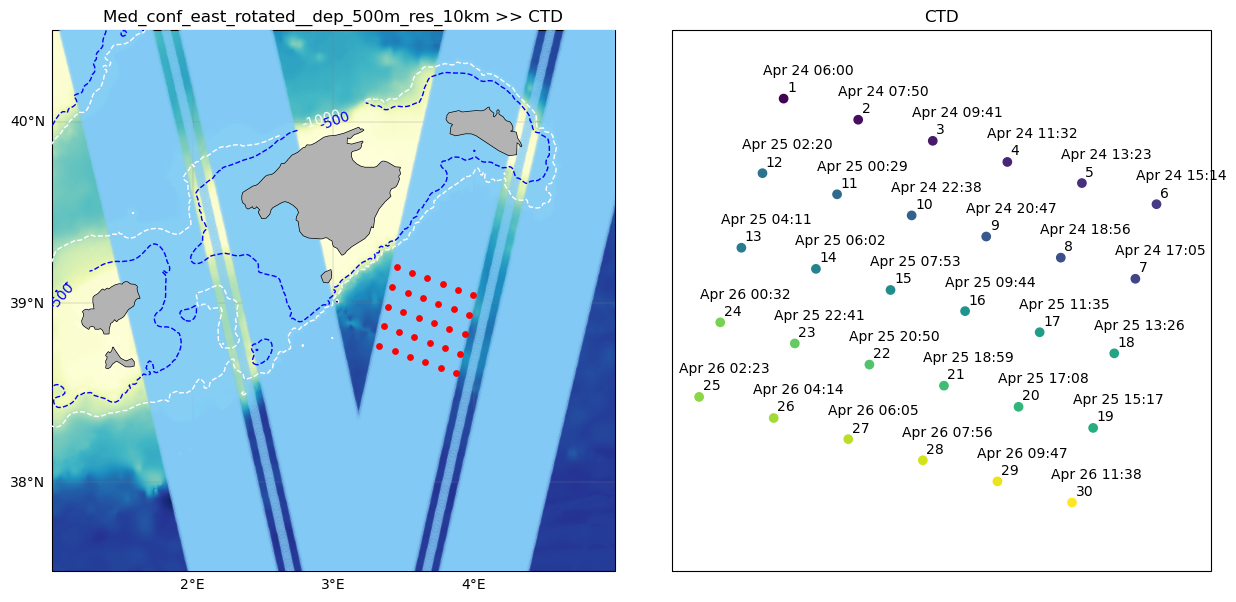

In [35]:
fsize = 12
fig = plt.figure(figsize=(13, 6))
ax = plt.subplot(121,projection=ccrs.Mercator())
# call the function
make_figure_CTD(ax, fsize, lonmin, lonmax, latmin, latmax)